In [4]:
%load_ext autoreload
%autoreload true

In [3]:
import sys
sys.path.insert(0, '../..')

import pandas as pd

import matplotlib.pyplot as plt

from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import accuracy_score

from utils import DataManager
from Boiler_Eta import *

# Instantiation of the best model

In [5]:
from sklearn.ensemble import RandomForestClassifier

# Best model from hyper optimisation
model = RandomForestClassifier(bootstrap=False, class_weight='balanced_subsample',
                       criterion='entropy', max_features=0.9817181130200501,
                       min_samples_leaf=3, n_estimators=49, n_jobs=20,
                       random_state=1, verbose=False)

# Loading train data and training model

In [6]:
loader = BoilerFaultLoader(os.path.join(DATA_ROOT, 'BoilerNoise-20220208')) 

train_faults = pd.read_csv(TRAIN_SPEC, index_col=0)
data_train, metadata_train = loader.load_fault_dataset_df(list(train_faults.index.values))
dm_train = DataManager()
dm_train.prepare_database(data_train, metadata_train, del_cols=HIDDEN_VARS+['anomaly'])

X_train, y_train = dm_train.split_X_Y_concat()

In [7]:
model.fit(X_train, y_train)

RandomForestClassifier(bootstrap=False, class_weight='balanced_subsample',
                       criterion='entropy', max_features=0.9817181130200501,
                       min_samples_leaf=3, n_estimators=49, n_jobs=20,
                       random_state=1, verbose=False)

# Load test data and computing predictions

In [8]:
test_faults = pd.read_csv(TEST_SPEC, index_col=0)
data_test , metadata_test = loader.load_fault_dataset_df(list(test_faults.index.values))
dm_test = DataManager()
dm_test.prepare_database(data_test, metadata_test, del_cols=HIDDEN_VARS+['anomaly'])

X_test, y_test = dm_test.split_X_Y_concat()

y_pred = model.predict(X_test)

# Computing model scores

In [9]:
mcc = matthews_corrcoef(y_test,	y_pred)
print("MCC: %.3f" % mcc)

acc = accuracy_score(y_test, y_pred)
print("Accuracy: %.3f" % acc)

MCC: 0.944
Accuracy: 0.972


# Plotting sample results

In [10]:
X_test_plot, y_test_plot = dm_test.split_X_Y()

for p in y_test_plot:
    p.index = pd.TimedeltaIndex(300 * p.index, unit='s')


In [14]:
from Yacine.model_evaluation_plots import plot_proba, plot_true_false

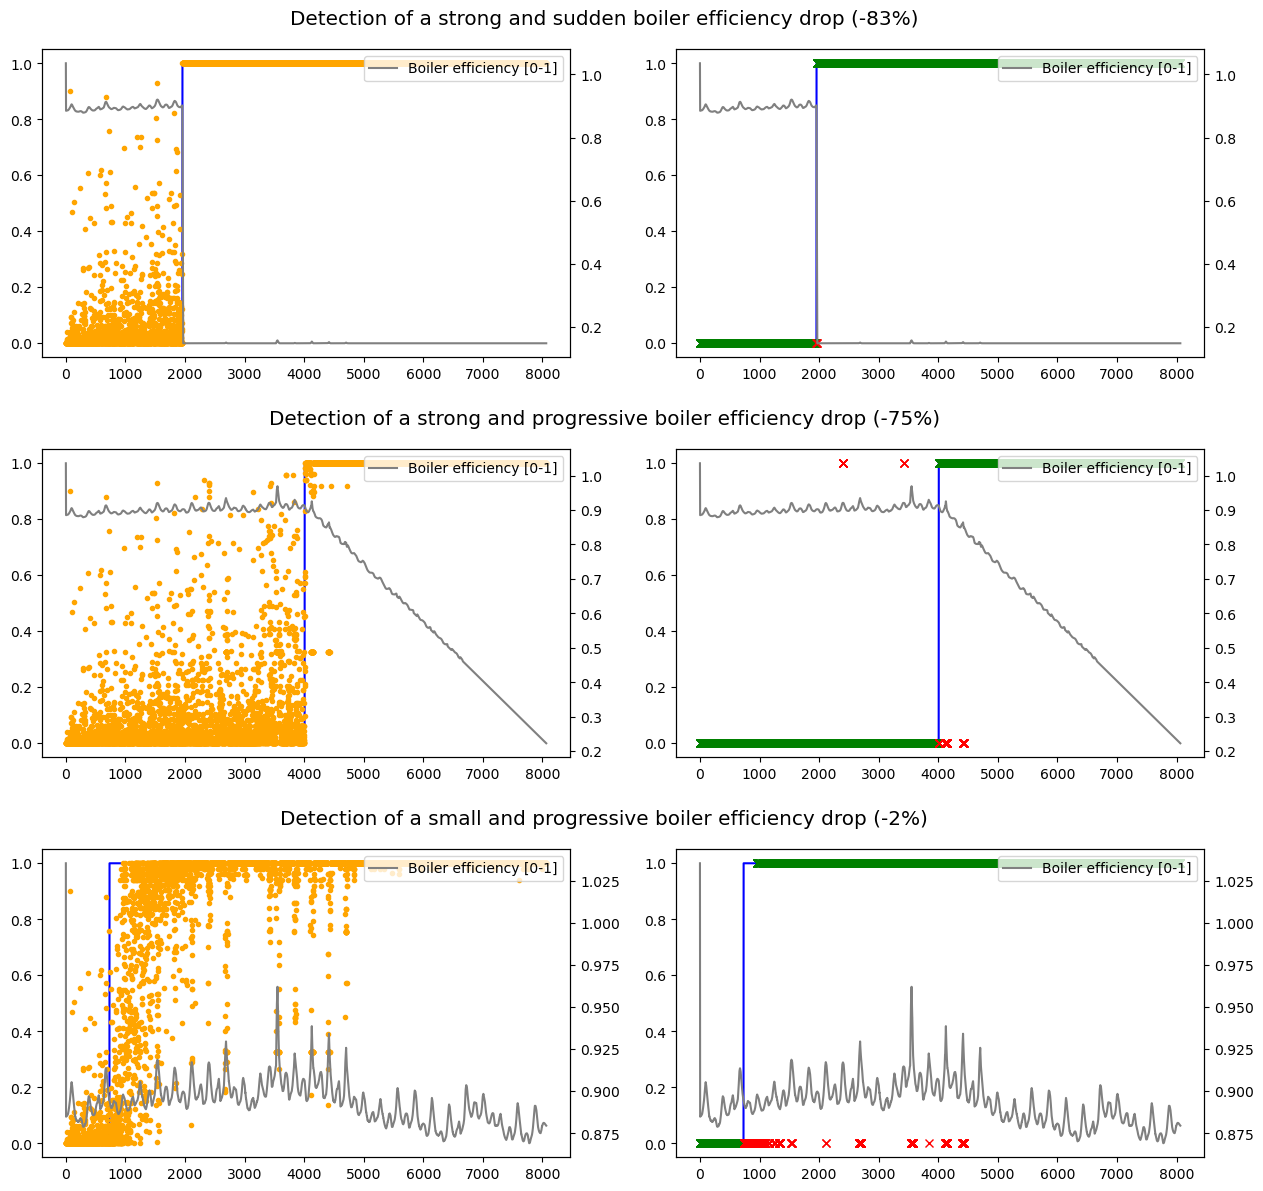

In [19]:
fault_var = 'Boiler_Eta'
fault_var_label = 'Boiler efficiency [0-1]'

test_ids = [9,7,3]
titles = [
    'Detection of a strong and sudden boiler efficiency drop (-83%)',
    'Detection of a strong and progressive boiler efficiency drop (-75%)',
    'Detection of a small and progressive boiler efficiency drop (-2%)',
]

nb_test = len(test_ids)
fig = plt.figure(figsize=(15,4*nb_test))

subfigs = fig.subfigures(nrows=nb_test, ncols=1)
for row, subfig in enumerate(subfigs):
    subfig.suptitle(titles[row], fontsize='x-large')

    ax = subfig.subplots(nrows=1, ncols=2)

    ii = test_ids[row]
    y_data = y_test_plot[ii].values.astype(np.float64)
    y_prob = model.predict_proba(X_test_plot[ii])[:,1]
    y_pred = alert_trigger(horizon=6, proba=y_prob, threshold=0.5)
    fault_var_data = dm_test.del_cols_data[ii][fault_var].values.astype(np.float64)

    plot_proba(ax[0], y_data, y_prob, fault_var_label, fault_var_data)
    plot_true_false(ax[1], y_data, y_pred, fault_var_label, fault_var_data) 